In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# key directories
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
import illustris_python as il
import Corrfunc
from Corrfunc.theory.xi import xi
import astropy.units as u
import os
import sys
sys.path.insert(0, work)
import corrfunc_ls
from illustris_sim import IllustrisSim
from illustris_xi import compute_xi_auto_illustris
import tools

We want to compute the cross-correlation between DM particles (this is the "true" underlying density field) and galaxies (a single position for each galaxy -> these are the subfind subhalos from the Illustris group catalogs).

#### parameters

In [4]:
z = 0.
# initialize simulation and snapshot
sim = IllustrisSim('TNG300-3')
sim.set_snapshot(redshift=z)

### data sets to use

#### DM particles

In [5]:
sim.load_dm_pos()
dm_subsample = tools.get_subsample(sim.dm_pos, nx=100).value
print(f"using {len(dm_subsample)} DM particles")

subsampling 2441406 random particles...
using 2441406 DM particles


#### galaxies

In [6]:
fields = ['SubhaloFlag','SubhaloPos','SubhaloMass','SubhaloMassType', 'SubhaloLenType']
subhalos = il.groupcat.loadSubhalos(sim.basepath, sim.snapshot, fields=fields)
print(f"loaded {subhalos['count']} subhalos")

loaded 391144 subhalos


In [7]:
# remove any subhalos flagged as non-cosmological in origin
subhalo_idx = subhalos['SubhaloFlag']
# unpack and give proper units
# (x,y,z) coordinate of each subhalo:
subhalo_pos = (subhalos['SubhaloPos'][subhalo_idx] * u.kpc).to(u.Mpc)
# total mass of each subhalo:
total_mass = subhalos['SubhaloMass'][subhalo_idx] * 1e10 * u.M_sun
# total mass of each particle type in each subhalo:
mass_types = subhalos['SubhaloMassType'][subhalo_idx] * 1e10 * u.Msun
# total number of each particle type in each subhalo:
len_types = subhalos['SubhaloLenType'][subhalo_idx]
print(f"removed {np.sum(~subhalo_idx)} subhalos")

removed 354 subhalos


In [10]:
# galaxies -> take only subhalos with non-zero star mass
#   and with at least 100 star particles (following Barreira et al 2021)
gal_idx = np.where((mass_types[:,4].value>0.) & (len_types[:,4]>100))
gal_pos = subhalo_pos[gal_idx]
gal_mass = total_mass[gal_idx]
gal_mass_types = mass_types[gal_idx]
gal_len_types = len_types[gal_idx]
print(f"{len(gal_pos)} subhalos with non-zero star mass")

4377 subhalos with non-zero star mass


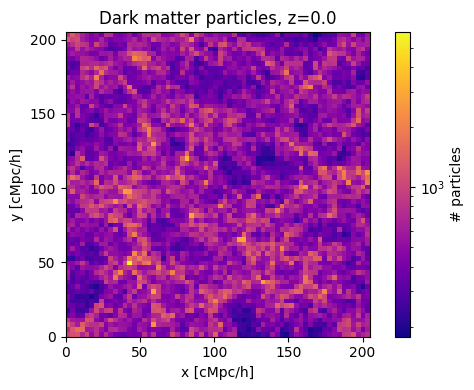

In [11]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_subsample[:,0], dm_subsample[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title(f'Dark matter particles, z={z}')
fig.tight_layout()

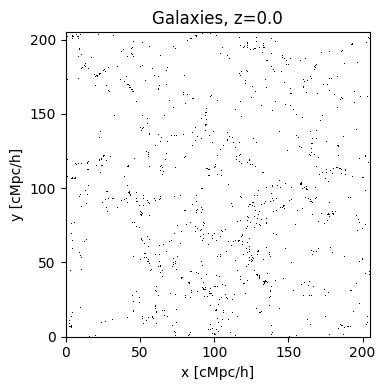

In [12]:
fig, ax = plt.subplots(figsize=(5.5,4))
# slice
zslice = np.where(gal_pos[:,2].value<50.)
ax.plot(gal_pos[:,0][zslice].value, gal_pos[:,1][zslice].value, ls='None', marker=',', color='k')
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
ax.set_title(f'Galaxies, z={z}')
fig.tight_layout()

### galaxy autocorrelation

In [13]:
# load in computed results
xi_gal_auto = np.load(os.path.join(scratch, f'xi/xi_gal_{sim.sim}_z-{z:.2f}.npy'), allow_pickle=True).item()
xi_dm_auto = np.load(os.path.join(scratch, f'xi/xi_dm_{sim.sim}_z-{z:.2f}_nx-100.npy'), allow_pickle=True).item()
# check that we use the same bins
assert np.all(xi_gal_auto['ravg'])==np.all(xi_dm_auto['ravg'])

In [14]:
# parameters
randmult = 3
rmin = xi_gal_auto['rmin']
rmax = xi_gal_auto['rmax']
nbins = xi_gal_auto['nbins']
nthreads = 12
print(rmin, rmax, nbins)

0.1 50.0 20


In [33]:
%%time
nrepeats = 1000
xi_gals = np.empty((nrepeats,nbins))
for i in range(nrepeats):
    ravg, xi_gals[i] = corrfunc_ls.compute_3D_ls_auto(gal_pos.value, randmult, rmin, rmax,
                                        nbins, logbins=True, periodic=True, nthreads=nthreads, prints=False)
xi_gal = np.mean(xi_gals, axis=0)

CPU times: user 17min 13s, sys: 2.12 s, total: 17min 15s
Wall time: 1min 30s


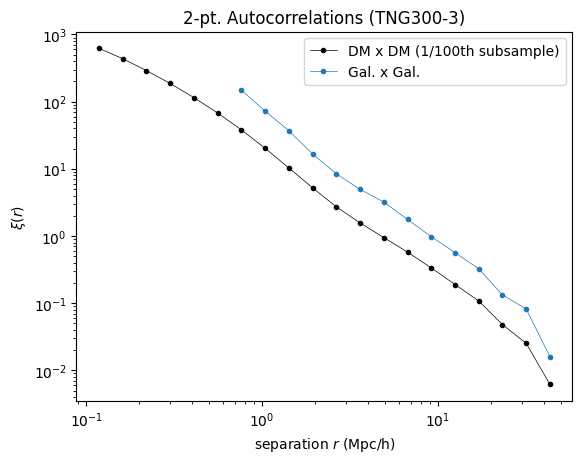

In [34]:
fig, ax = plt.subplots()
# ax.plot(xi_gal_auto['ravg'], xi_gal_auto['xi'], 'C0.-', lw=0.5, label='Gal. x Gal.')
ax.plot(xi_dm_auto['ravg'], xi_dm_auto['xi'], 'k.-', lw=0.5, label='DM x DM (1/100th subsample)')
ax.plot(ravg, xi_gal, marker='.', color='C0', lw=0.5, label=f'Gal. x Gal.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Autocorrelations ({sim.sim})')
ax.legend()

In [35]:
# ratio
ratio = xi_gal / xi_dm_auto['xi']

Text(0.5, 1.0, '(Gal x Gal) / (DM x DM)')

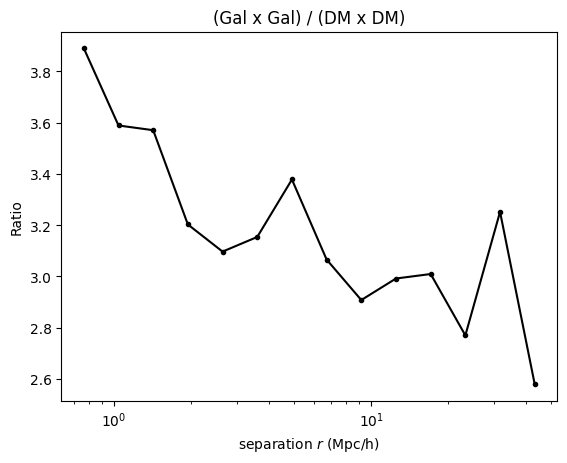

In [36]:
fig, ax = plt.subplots()
ax.plot(ravg, ratio, marker='.', color='k')
ax.set_xscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'Ratio')
ax.set_title(f'(Gal x Gal) / (DM x DM)')

### cross-correlation: gal x DM

Landy-Szalay estimator:
$$
\xi_\mathrm{DM,gal}(r)=\frac{D_\mathrm{gal}D_\mathrm{DM}-2D_\mathrm{gal}R_\mathrm{DM}+R_\mathrm{DM}R_\mathrm{DM}}{R_\mathrm{DM}R_\mathrm{DM}}
$$

In [57]:
# set up data for calculation
tracersforcf = corrfunc_ls.set_up_cf_data(dm_subsample, randmult, rmin, rmax, nbins, logbins=True, dtype='float32')
r_edges, r_avg, nd, boxsize, nr, rand_set, tracer_set = tracersforcf.values()

In [58]:
# unpack data
xgal, ygal, zgal = gal_pos.value.T
xdm, ydm, zdm = tracer_set.T
xr, yr, zr = rand_set.T

nthreads = 12
periodic = True

In [59]:
print(f"{len(xgal)} galaxies \n{len(xdm)} DM particles \n{len(xr)} random points ({randmult}x DM set)")

1161 galaxies 
2441406 DM particles 
7324218 random points (3x DM set)


In [60]:
%%time
# DD: galaxy data x DM data
results_DD = Corrfunc.theory.DD(0, nthreads, r_edges, xgal, ygal, zgal, X2=xdm, Y2=ydm, Z2=zdm,
                                boxsize=boxsize, periodic=periodic)

CPU times: user 703 ms, sys: 19.2 ms, total: 722 ms
Wall time: 71.9 ms


In [61]:
%%time
# DR: galaxy data x random set (3x number of DM particles)
results_DR = Corrfunc.theory.DD(0, nthreads, r_edges, xgal, ygal, zgal, X2=xr, Y2=yr, Z2=zr,
                                boxsize=boxsize, periodic=periodic)

CPU times: user 1.96 s, sys: 19.5 ms, total: 1.98 s
Wall time: 199 ms


In [62]:
%%time
# RR: random set x random set
results_RR = Corrfunc.theory.DD(1, nthreads, r_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

CPU times: user 34min 18s, sys: 219 ms, total: 34min 18s
Wall time: 2min 52s


In [63]:
rr_save_fn = os.path.join(scratch, f'xi/randoms/rr_{sim.sim}_{len(xr)}.npy')
np.save(rr_save_fn, results_RR)

In [64]:
dd = np.array([x['npairs'] for x in results_DD], dtype=float)
dr = np.array([x['npairs'] for x in results_DR], dtype=float)
rr = np.array([x['npairs'] for x in results_RR], dtype=float)

In [65]:
nd, nr, nr/nd

(2441406, 7324218, 3.0)

In [66]:
len(gal_pos), len(dm_subsample)

(1161, 2441406)

In [67]:
results_xi = Corrfunc.utils.convert_3d_counts_to_cf(len(gal_pos), nd, nr, nr, dd, dr, dr, rr)

Text(0.5, 1.0, 'Gal. x DM (TNG300-3)')

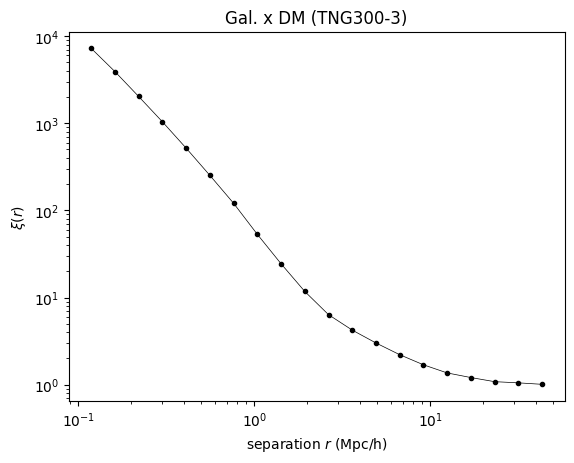

In [68]:
fig, ax = plt.subplots()
ax.plot(r_avg, results_xi, 'k.-', lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'Gal. x DM ({sim.sim})')

### compare DM and galaxy autocorrelations

In [55]:
xi_gal_auto = np.load(os.path.join(scratch, f'xi/xi_gal_{sim.sim}_z-{z:.2f}.npy'), allow_pickle=True).item()
xi_dm_auto = np.load(os.path.join(scratch, f'xi/xi_dm_{sim.sim}_z-{z:.2f}_nx-100.npy'), allow_pickle=True).item()

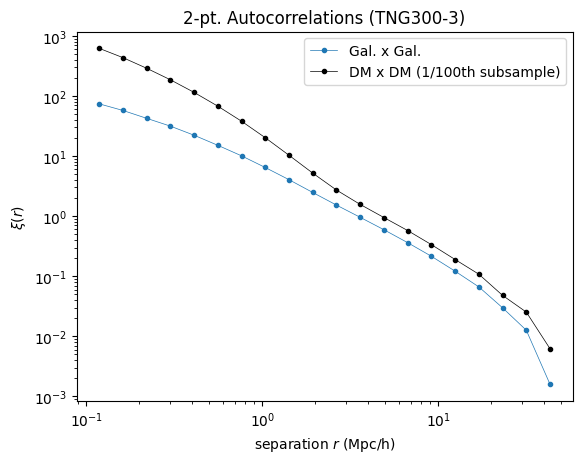

In [70]:
fig, ax = plt.subplots()
ax.plot(xi_gal_auto['ravg'], xi_gal_auto['xi'], 'C0.-', lw=0.5, label='Gal. x Gal.')
ax.plot(xi_dm_auto['ravg'], xi_dm_auto['xi'], 'k.-', lw=0.5, label='DM x DM (1/100th subsample)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Autocorrelations ({sim.sim})')
ax.legend()

In [69]:
# ratio: (Gal x Gal) / (DM x DM)
ratio = xi_gal_highmass / xi_dm_auto['xi']

Text(0.5, 1.0, '(Gal x DM)/(DM x DM)')

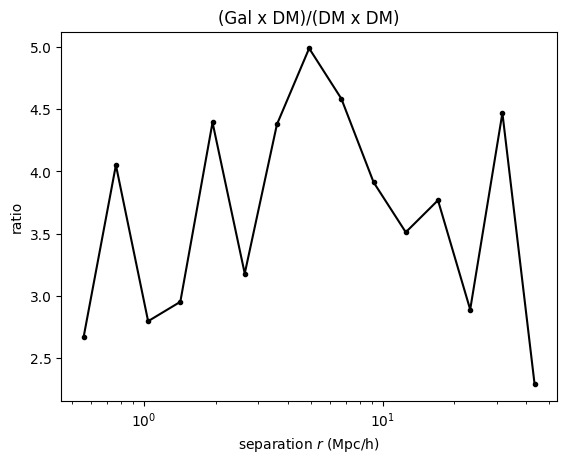

In [71]:
fig, ax = plt.subplots()
ax.plot(r_avg, ratio, 'k.-')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'ratio')
ax.set_title(f'(Gal x Gal)/(DM x DM)')